In [2]:
from pathlib import Path
from typing import List
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import scipy.signal as sc
import numpy as np
import csv

In [4]:
import zipfile as zf
files = zf.ZipFile("hmog_dataset/public_dataset/100669.zip", 'r')
files.extractall('100669/')
files.close()

In [5]:

# data pre processing
base_data_folder_path = Path('public_dataset')
file_name_to_colume_names = {
    'Accelerometer.csv': ['ASystime', 'AEventTime', 'AActivityID', 'AX', 'AY', 'AZ', 'APhone_orientation'],
    'Activity.csv': ['ID', 'SubjectID', 'Start_time', 'End_time', 'Relative_Start_time', 'Relative_End_time',
                     'Gesture_scenario', 'TaskID', 'ContentID'],
    'Gyroscope.csv': ['GSystime', 'GEventTime', 'GActivityID', 'GX', 'GY', 'GZ', 'GPhone_orientation']
}

In [6]:
def get_user_session_data(user_id: str, user_session_id: str) -> DataFrame:
    """
    Combine accelerometer, gyroscope, and activity labels for a specific session of a user
    Note: Timestamps are ignored when joining accelerometer and gyroscope data.
    :param user_id: user id
    :param user_session_id: user session id
    :return: combined DataFrame for a session
    """
    acc = pd.read_csv('Accelerometer.csv', header = None, names = file_name_to_colume_names['Accelerometer.csv'])
    gyr = pd.read_csv('Gyroscope.csv', header = None, names = file_name_to_colume_names['Gyroscope.csv'])
    
   # path = user_id + '_session_' + user_session_id 
   # pd.read_csv(path+'/Accelerometer.csv')
   # pd.read_csv(path+'/Gyroscope.csv')
   
    return  pd.concat([acc, gyr], axis = 1)    

    

In [9]:
# pick the user as well as activities and extract 3 out of 6 features 
session1_100669 = get_user_session_data ('100669','1')
# I am picking accelerometer X, Y and Gyroscope X
# visualize of the features you pick
X = session1_100669['AX']
Y = session1_100669['AY']
Z = session1_100669['GZ']
Time = session1_100669['ASystime']


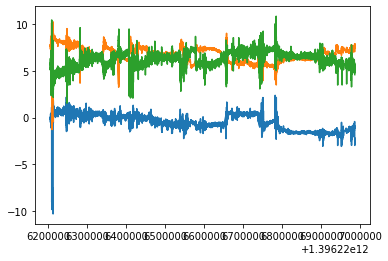

In [10]:
# Initial visualization - Accelerometer
plt.plot(Time, X)
plt.plot(Time, Y)
plt.plot(Time, session1_100669['AZ'])

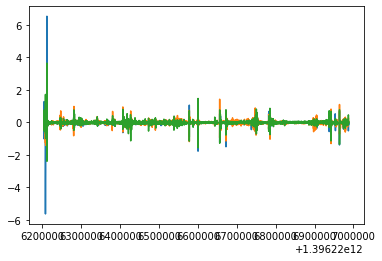

In [12]:
# Initial visualization - Gyroscope
plt.plot(session1_100669['GSystime'], Z)
plt.plot(session1_100669['GSystime'], session1_100669['GX'])
plt.plot(session1_100669['GSystime'], session1_100669['GY'])

Both plot show that the change for X, Y and Z of both sensors tend to be simultaneous. This makes sense because when a certain touch event happens, it tends to change the state of the smart phone comprehensively.

In [130]:
def coeff_extrema(nbddata: DataFrame, degree: int) -> list:  
    """
    Find local maximum in the data series and fit polynomial to get the coefficients.
    :param nbddata: neighborhood of time t_i containing (t, x(t), y(t), z(t)), 
    where x(t), y(t), z(t) are the 3 out of the 6 features. 
    :param degree: the degree fo the polynomial to fit into the data
    :return: list of coefficients around each local maxima value
    """
    max = sc.argrelextrema(nbddata['AX'].values,np.greater)
    coeff = []
    for i in max[0]:
        c1 = np.polyfit(nbddata['AX'][i-5: i+5], nbddata['ASystime'][i-5:i+5], degree)
        c2 = np.polyfit(nbddata['AY'][i-5: i+5], nbddata['ASystime'][i-5:i+5], degree)
        c3 = np.polyfit(nbddata['GZ'][i-5: i+5], nbddata['ASystime'][i-5:i+5], degree)
        coeff.append([c1,c2,c3])
    return coeff

In [153]:
def multiV_curvature(nbddata: DataFrame) -> list:  
    """
    Calculate multi V curvature
    :param nbddata:  neighborhood of time t_i containing (t, x(t), y(t), z(t)), 
    where x(t), y(t), z(t) are the 3 out of the 6 features. 
    :return: multi V curvature for each individual coefficient point
    """
    coefficient = coeff_extrema(nbddata, 2)
    curvature = []
    for lcoef in coefficient:
        lcoef1 = np.array([np.array(xi) for xi in lcoef])
        # First order derivative 
        fod = lcoef1[:, 1]
        # Second order derivative
        sod = 2 * lcoef1[:, 0]
        curv = np.linalg.norm(np.cross(fod, sod))/(np.linalg.norm(fod)**3)
        curvature.append(curv)
    return curvature

In [161]:
def multiV_torsion(nbddata: DataFrame) -> list:  
    """
    Calculate multi V torsion
    :param nbddata: neighborhood of time t_i containing (t, x(t), y(t), z(t)), 
    where x(t), y(t), z(t) are the 3 out of the 6 features. 
    :return: multi V torsion
    """
    coefficient = coeff_extrema(nbddata, 3)
    torsion = []
    for lcoef in coefficient:
        lcoef1 = np.array([np.array(xi) for xi in lcoef])
        # First order derivative 
        fod = lcoef1[:, 2]
        # Second order derivative
        sod = 2 * lcoef1[:, 1]
        # Third order derivative
        tod = 6 * lcoef1[:, 0]
        tor = 3 * np.linalg.det([fod, sod, tod])/(np.linalg.norm(np.cross(fod, sod))**2)
        torsion.append(tor)
    return torsion

In [163]:
# Calucate and plot curvature and torsion of the features you pick
features = pd.concat([Time, X, Y, Z], axis = 1)
curv = multiV_curvature(features)
print("Curvature is calculated.")
tors = multiV_torsion(features)
print("Torsion is calculated.")

Curvature is calculated.
Torsion is calculated.


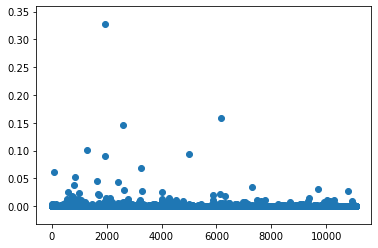

In [164]:
xc = list(range(len(curv)))
plt.scatter(xc, curv)


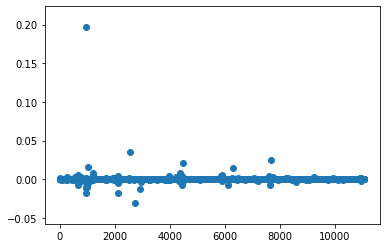

In [165]:
xt = list(range(len(tors)))
plt.scatter(xt, tors)